# Importing Libraries

The following libraries are used in this notebook:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import string
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


# Load and preview the dataset

In [2]:
df = pd.read_csv("OLIDv1.0\\olid-training-v1.0.tsv", sep="\t")
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


# Preprocessing tweets
# Replacing '@USER' and 'URL' with empty strings and handling missing values

In [3]:
# Assuming 'column_name' is the column you want to modify:
for i in range(df.shape[0]):
    df.loc[i, "tweet"] = df.loc[i, "tweet"].replace("@USER", "")
    df.loc[i, "tweet"] = df.loc[i, "tweet"].replace("URL", "")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


In [5]:
df.describe()

,id
count,13240.000000
mean,54881.766163
std,26092.681658
min,10006.000000
25%,32235.750000
50%,54852.000000
75%,77743.250000
max,99986.000000


In [6]:
df = df.fillna({"subtask_a": "NOT", "subtask_b": "UNT", "subtask_c": "OTH"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  13240 non-null  object
 4   subtask_c  13240 non-null  object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


In [7]:
df["subtask_a"].value_counts()

subtask_a
NOT    8840
OFF    4400
Name: count, dtype: int64

In [8]:
df["subtask_b"].value_counts()

subtask_b
UNT    9364
TIN    3876
Name: count, dtype: int64

In [9]:
df["subtask_c"].value_counts()

subtask_c
OTH    9759
IND    2407
GRP    1074
Name: count, dtype: int64

In [10]:
df["subtask_a"] = df["subtask_a"].map({"NOT": 0, "OFF": 1})
df["subtask_b"] = df["subtask_b"].map({"TIN": 1, "UNT": 0})

In [11]:
df["subtask_c"] = df["subtask_c"].map({"IND": 1, "GRP": 2, "OTH": 3})

In [12]:
df.isna().sum()

id           0
tweet        0
subtask_a    0
subtask_b    0
subtask_c    0
dtype: int64

# Tokenizing tweets

In [13]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove special characters, numbers, and punctuations (except for hashtags and @mentions)
    text = re.sub("[^a-zA-Z#@0-9]", " ", text)
    # Convert to lowercase
    text = text.lower()

    text = " ".join(
        [word for word in text.split() if word not in stopwords.words("english")]
    )
    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]
    exclude = string.punctuation
    words = [word for word in words if word not in exclude]

    # Lemmatize words based on POS tags
    lemmatizer = WordNetLemmatizer()
    tagged_words = pos_tag(words)
    lemmatized_words = []
    for word, tag in tagged_words:
        if tag.startswith("NN"):  # Noun
            pos = "n"
        elif tag.startswith("VB"):  # Verb
            pos = "v"
        elif tag.startswith("JJ"):  # Adjective
            pos = "a"
        else:
            pos = "n"  # Default to noun
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))
    text = " ".join(lemmatized_words)
    return text

In [14]:
df["tweet"] = df["tweet"].apply(preprocess_text)

In [15]:
X = df["tweet"]

# SUBTASK_A

In [16]:
y_subtask_a = df["subtask_a"]

In [17]:
y_subtask_a.value_counts()

subtask_a
0    8840
1    4400
Name: count, dtype: int64

In [18]:
df["subtask_a"].value_counts()

subtask_a
0    8840
1    4400
Name: count, dtype: int64

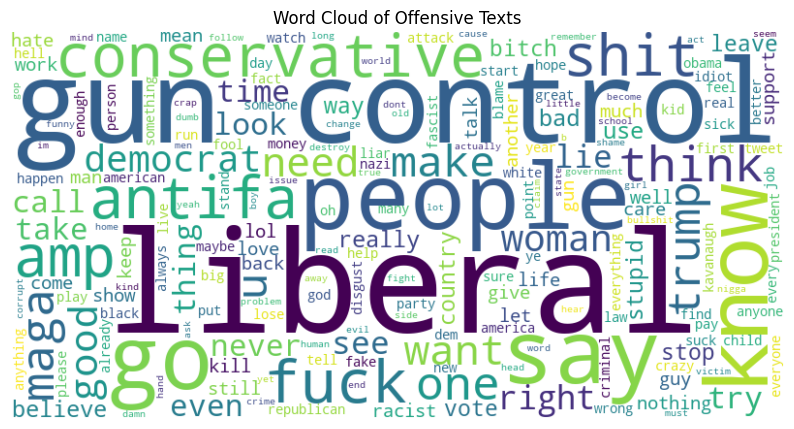

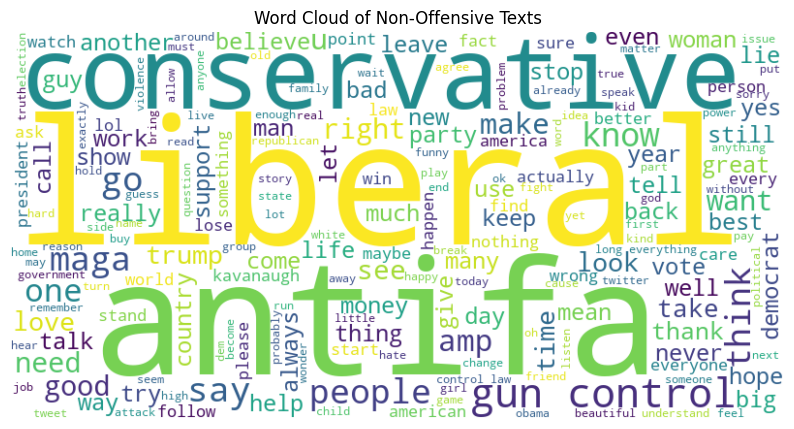

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

offensive_text = " ".join(text for text in df[df["subtask_a"] == 1].tweet)
wordcloud_off = WordCloud(width=800, height=400, background_color="white").generate(
    offensive_text
)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_off, interpolation="bilinear")  # Use the WordCloud object
plt.axis("off")
plt.title("Word Cloud of Offensive Texts")
plt.show()

# Generating and displaying the word cloud for non-offensive texts
not_offensive_texts = " ".join(text for text in df[df["subtask_a"] == 0].tweet)
wordcloud_not = WordCloud(width=800, height=400, background_color="white").generate(
    not_offensive_texts
)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_not, interpolation="bilinear")  # Use the WordCloud object
plt.axis("off")
plt.title("Word Cloud of Non-Offensive Texts")
plt.show()

In [20]:
y_subtask_a

0        1
1        1
2        0
3        1
4        0
        ..
13235    1
13236    0
13237    1
13238    1
13239    0
Name: subtask_a, Length: 13240, dtype: int64

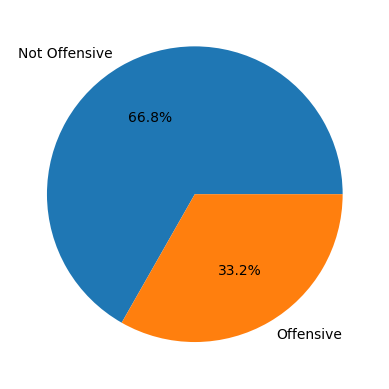

In [21]:
plt.pie(
    y_subtask_a.value_counts(), labels=["Not Offensive", "Offensive"], autopct="%1.1f%%"
)
plt.savefig("barchart.png")
plt.show()

## Splitting the dataset into training and testing sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_subtask_a, test_size=0.2, random_state=42
)

## Vectorizing tweets

In [23]:
tfidf_vectorizer = TfidfVectorizer()

In [24]:
X_train = tfidf_vectorizer.fit_transform(X_train)

In [25]:
X_test = tfidf_vectorizer.transform(X_test)

In [26]:
X_train.shape

(10592, 14002)

In [71]:
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    auc,
)

def evaluate_model(model, X_test, y_test, model_name, evaluation_dict):
    # Generate predictions
    y_pred = model.predict(X_test)

    # Extended classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print("Classification Report for", model_name)
    print(classification_report(y_test, y_pred))

    # Detailed confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    x_labels = [f"Pred {cls}" for cls in np.unique(y_test)]
    y_labels = [f"True {cls}" for cls in np.unique(y_test)]
    cm_figure = ff.create_annotated_heatmap(
        z=cm, x=x_labels, y=y_labels, colorscale="Blues", showscale=True
    )
    cm_figure.update_layout(title_text=f"Confusion Matrix for {model_name}")
    cm_figure.show()

    # Check for predict_proba or decision_function
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
        if len(y_prob.shape) == 1:  # Binary classification
            y_prob = (y_prob - y_prob.min()) / (
                y_prob.max() - y_prob.min()
            )  # Scale to 0-1
            y_prob = np.vstack([1 - y_prob, y_prob]).T  # Convert to two columns
    else:
        raise RuntimeError(
            "Model does not have predict_proba or decision_function method."
        )

    # Handling binary and multiclass cases
    if y_prob.shape[1] == 2:  # Binary classification
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_figure = go.Figure()
        roc_figure.add_trace(
            go.Scatter(
                x=fpr, y=tpr, mode="lines", name=f"ROC Curve (area = {roc_auc:.2f})"
            )
        )
        roc_figure.add_shape(
            type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1
        )
        roc_figure.update_layout(
            title=f"ROC Curve for {model_name} (AUC = {roc_auc:.2f})",
            xaxis_title="False Positive Rate",
            yaxis_title="True Positive Rate",
        )
        roc_figure.show()
    else:  # Multiclass classification
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_prob.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        roc_figure = go.Figure()
        for i in range(y_prob.shape[1]):
            roc_figure.add_trace(
                go.Scatter(
                    x=fpr[i],
                    y=tpr[i],
                    mode="lines",
                    name=f"Class {i} (area = {roc_auc[i]:.2f})",
                )
            )
        roc_figure.add_shape(
            type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1
        )
        roc_figure.update_layout(
            title=f"ROC Curve for {model_name}",
            xaxis_title="False Positive Rate",
            yaxis_title="True Positive Rate",
        )
        roc_figure.show()

    # Store evaluation metrics in the dictionary
    evaluation_dict[model_name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1_score": f1_score(y_test, y_pred, average="macro"),
        "roc_auc": (
            roc_auc
            if isinstance(roc_auc, dict)
            else roc_auc_score(y_test, y_prob[:, 1])
        ),
        "classification_report": report,
        "confusion_matrix": cm,
    }

In [28]:
evaluation_dict_subtask_a = {}

## Machine Learning Models
### Logistic Regression

In [29]:
from sklearn.model_selection import GridSearchCV

logistic = LogisticRegression(random_state=42)

# Define hyperparameters to tune
parameters = {
    "C": [0.1, 1, 10, 100],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(logistic, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate the model
evaluate_model(
    grid_search.best_estimator_,
    X_test,
    y_test,
    "Logistic Regression",
    evaluation_dict_subtask_a,
)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1733
           1       0.69      0.53      0.60       915

    accuracy                           0.76      2648
   macro avg       0.74      0.70      0.71      2648
weighted avg       0.75      0.76      0.75      2648



Best Parameters: {'C': 10}
Best Score: 0.7582134480916177


### Support Vector Machine

In [30]:
svm = SVC(random_state=42)

parameters = {"C": [0.1, 1, 10]}

grid_search = GridSearchCV(svm, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

evaluate_model(
    grid_search.best_estimator_, X_test, y_test, "SVM", evaluation_dict_subtask_a
)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Classification Report for SVM
              precision    recall  f1-score   support

           0       0.77      0.91      0.83      1733
           1       0.74      0.48      0.58       915

    accuracy                           0.76      2648
   macro avg       0.75      0.70      0.71      2648
weighted avg       0.76      0.76      0.75      2648



Best Parameters: {'C': 10}
Best Score: 0.7643501999312841


### Gaussian Naive Bayes

In [31]:
naive_bayes = MultinomialNB()

# Define hyperparameters to tune
parameters = {"alpha": [0.1, 0.5, 1.0], "fit_prior": [True, False]}
# Perform grid search with cross-validation
grid_search = GridSearchCV(naive_bayes, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
naive_bayes_model = grid_search.best_estimator_
# Save the best model


# Evaluate the best model
evaluate_model(
    naive_bayes_model, X_test, y_test, "Naive Bayes", evaluation_dict_subtask_a
)

Best Parameters: {'alpha': 0.5, 'fit_prior': True}
Best Score: 0.7302677648738581
Classification Report for Naive Bayes
              precision    recall  f1-score   support

           0       0.71      0.96      0.82      1733
           1       0.78      0.27      0.40       915

    accuracy                           0.72      2648
   macro avg       0.75      0.61      0.61      2648
weighted avg       0.74      0.72      0.67      2648



### Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=42)


# Define hyperparameters to tune
parameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 50, 100, None],
}

grid_search = GridSearchCV(random_forest, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

random_forest = grid_search.best_estimator_
# Evaluate the best model
evaluate_model(
    random_forest, X_test, y_test, "Random Forest", evaluation_dict_subtask_a
)

Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1733
           1       0.77      0.46      0.57       915

    accuracy                           0.77      2648
   macro avg       0.77      0.69      0.71      2648
weighted avg       0.77      0.77      0.75      2648



In [33]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'n_estimators': 200}
Best Score: 0.7728471346747646


## Deep Learning Models


In [34]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["tweet"])
X = pad_sequences(tokenizer.texts_to_sequences(df["tweet"]), maxlen=50, padding="post")

### LSTM

In [35]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_subtask_a, test_size=0.2, random_state=42
)

# LSTM Model
model_a_lstm = Sequential(
    [
        Embedding(input_dim=5000, output_dim=64, input_length=50),
        LSTM(64, return_sequences=True),
        Dropout(0.5),
        LSTM(32),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)
model_a_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_a_lstm = model_a_lstm.fit(
    X_train, y_train, epochs=10, validation_data=(X_test, y_test)
)

Epoch 1/10


c:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.6766 - loss: 0.6358 - val_accuracy: 0.6545 - val_loss: 0.6435
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6723 - loss: 0.6214 - val_accuracy: 0.6545 - val_loss: 0.6347
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6735 - loss: 0.6285 - val_accuracy: 0.6545 - val_loss: 0.6458
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6687 - loss: 0.6355 - val_accuracy: 0.6545 - val_loss: 0.6472
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6745 - loss: 0.6312 - val_accuracy: 0.6545 - val_loss: 0.6447
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6708 - loss: 0.6339 - val_accuracy: 0.6545 - val_loss: 0.6449
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6658 - loss: 0.6371 - val_accuracy: 0.6545 - val_loss: 0.6455
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6671 - loss: 0.6367 - val_accurac

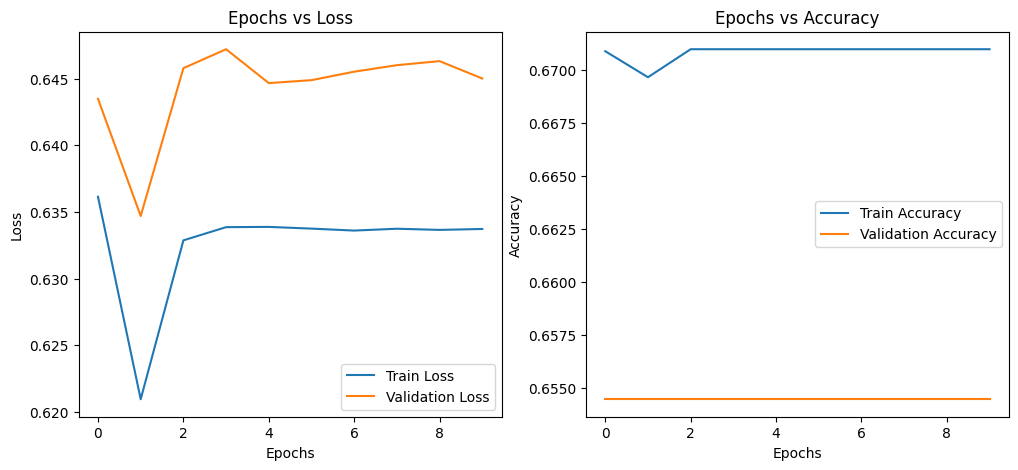

In [36]:
# plot epoch vs loss and epoch vs accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_a_lstm.history["loss"], label="Train Loss")
plt.plot(history_a_lstm.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_a_lstm.history["accuracy"], label="Train Accuracy")
plt.plot(history_a_lstm.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend()
plt.show()

### GRU

In [37]:
# GRU Model
model_a_gru = Sequential(
    [
        Embedding(input_dim=5000, output_dim=64, input_length=50),
        GRU(64, return_sequences=True),
        Dropout(0.5),
        GRU(32),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)
model_a_gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_a_gru = model_a_gru.fit(
    X_train, y_train, epochs=10, validation_data=(X_test, y_test)
)

Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.6753 - loss: 0.6389 - val_accuracy: 0.6545 - val_loss: 0.6453
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6728 - loss: 0.6336 - val_accuracy: 0.6545 - val_loss: 0.6464
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6632 - loss: 0.6396 - val_accuracy: 0.6545 - val_loss: 0.6457
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6715 - loss: 0.6341 - val_accuracy: 0.6545 - val_loss: 0.6471
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6809 - loss: 0.6261 - val_accuracy: 0.7255 - val_loss: 0.5966
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7813 - loss: 0.4875 - val_accuracy: 0.7647 - val_loss: 0.5090
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8584 - loss: 0.3397 - val_accuracy: 0.7489 - val_loss: 0.5469
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9153 - loss: 0.2465 - 

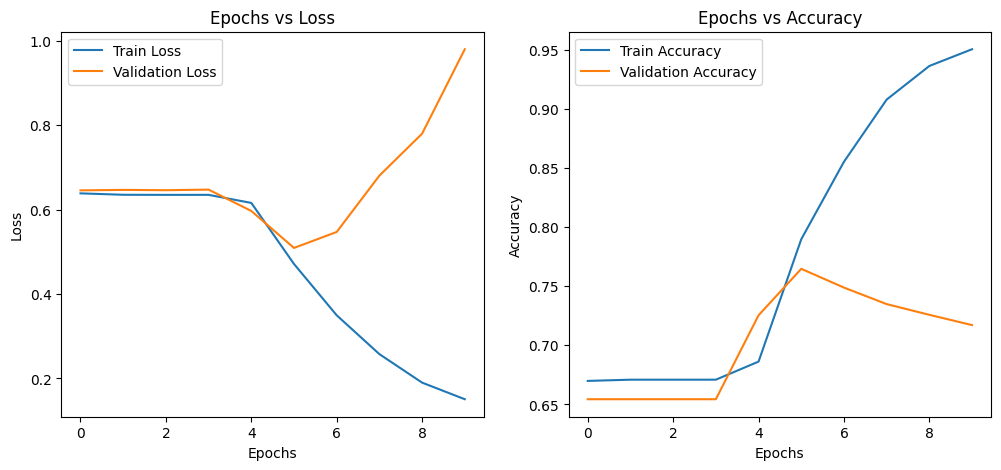

In [38]:
# plot epoch vs loss and epoch vs accuracy graphs

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_a_gru.history["loss"], label="Train Loss")
plt.plot(history_a_gru.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_a_gru.history["accuracy"], label="Train Accuracy")
plt.plot(history_a_gru.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend()
plt.show()

# Subtask B

In [39]:
y_subtask_b = df["subtask_b"]

In [40]:
y_subtask_b.value_counts()

subtask_b
0    9364
1    3876
Name: count, dtype: int64

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_subtask_b, test_size=0.2, random_state=42
)

## Vectorizing tweets

In [42]:
tfidf_vectorizer = TfidfVectorizer()
X = df["tweet"]
y = df["subtask_b"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [43]:
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [44]:
evaluation_dict_subtask_b = {}

## Machine Learning Models
### Logistic Regression 

In [45]:
logistic = LogisticRegression(random_state=42)
parameters = {
    "C": [0.1, 1, 10, 100],
}

grid_search = GridSearchCV(logistic, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
logistic = grid_search.best_estimator_
evaluate_model(
    logistic, X_test, y_test, "Logistic Regression", evaluation_dict_subtask_b
)

Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.76      0.95      0.85      1856
           1       0.72      0.29      0.42       792

    accuracy                           0.76      2648
   macro avg       0.74      0.62      0.63      2648
weighted avg       0.75      0.76      0.72      2648



### Support Vector Machine

In [46]:
svm = SVC(random_state=42)
parameters = {
    "C": [0.1, 1, 10],
}

grid_search = GridSearchCV(svm, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
svm = grid_search.best_estimator_
evaluate_model(svm, X_test, y_test, "SVM", evaluation_dict_subtask_b)

Classification Report for SVM
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1856
           1       0.68      0.41      0.51       792

    accuracy                           0.77      2648
   macro avg       0.73      0.66      0.68      2648
weighted avg       0.75      0.77      0.75      2648



### Gaussian Naive Bayes

In [47]:
naive_bayes = MultinomialNB()
parameters = {"alpha": [0.1, 0.5, 1.0], "fit_prior": [True, False]}

grid_search = GridSearchCV(naive_bayes, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
naive_bayes = grid_search.best_estimator_
evaluate_model(naive_bayes, X_test, y_test, "Naive Bayes", evaluation_dict_subtask_b)

Classification Report for Naive Bayes
              precision    recall  f1-score   support

           0       0.73      0.98      0.83      1856
           1       0.72      0.15      0.24       792

    accuracy                           0.73      2648
   macro avg       0.72      0.56      0.54      2648
weighted avg       0.73      0.73      0.66      2648



### Random Forest Classifier

In [48]:
random_forest = RandomForestClassifier(random_state=42)
parameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 50, 100, None],
}

grid_search = GridSearchCV(random_forest, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
random_forest = grid_search.best_estimator_
evaluate_model(
    random_forest, X_test, y_test, "Random Forest", evaluation_dict_subtask_b
)

Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1856
           1       0.70      0.37      0.48       792

    accuracy                           0.76      2648
   macro avg       0.74      0.65      0.66      2648
weighted avg       0.75      0.76      0.74      2648



## Deep Learning Models
### LSTM Model

In [50]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["tweet"])
X = pad_sequences(tokenizer.texts_to_sequences(df["tweet"]), maxlen=50, padding="post")

In [51]:
y_subtask_b = df["subtask_c"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_subtask_b, test_size=0.2, random_state=42
)
# X_train = tfidf_vectorizer.fit_transform(X_train)
# X_test = tfidf_vectorizer.transform(X_test)
model_b_lstm = Sequential(
    [
        Embedding(input_dim=5000, output_dim=64),
        LSTM(64, return_sequences=True),
        Dropout(0.5),
        LSTM(32),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)
model_b_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_b_lstm = model_b_lstm.fit(
    X_train, y_train, epochs=10, validation_data=(X_test, y_test)
)

# # Splitting data
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y_subtask_b, test_size=0.2, random_state=42
# )

# # LSTM Model
# model_a_lstm = Sequential(
#     [
#         Embedding(input_dim=5000, output_dim=64, input_length=50),
#         LSTM(64, return_sequences=True),
#         Dropout(0.5),
#         LSTM(32),
#         Dense(16, activation="relu"),
#         Dense(1, activation="sigmoid"),
#     ]
# )
# model_a_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# history_a_lstm = model_a_lstm.fit(
#     X_train, y_train, epochs=10, validation_data=(X_test, y_test)
# )

Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.1774 - loss: -36.2576 - val_accuracy: 0.1903 - val_loss: -192.3168
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1813 - loss: -287.1274 - val_accuracy: 0.1903 - val_loss: -633.2857
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1796 - loss: -797.0842 - val_accuracy: 0.1903 - val_loss: -1325.0308
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1842 - loss: -1543.2603 - val_accuracy: 0.1903 - val_loss: -2245.8296
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1781 - loss: -2548.6011 - val_accuracy: 0.1903 - val_loss: -3372.8362
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1801 - loss: -3733.5847 - val_accuracy: 0.1903 - val_loss: -4688.8071
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1771 - loss: -5110.4941 - val_accuracy: 0.1903 - val_loss: -6181.4639
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 

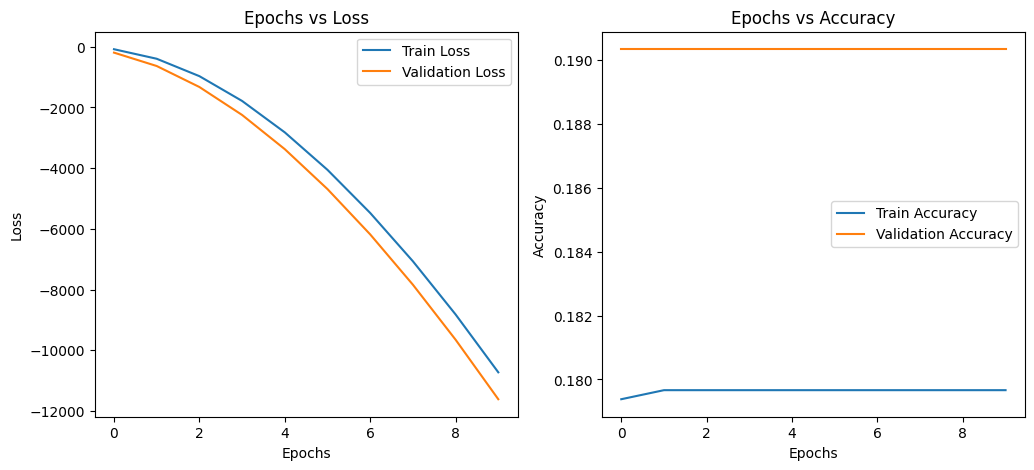

In [52]:
# plot epoch vs loss and epoch vs accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_b_lstm.history["loss"], label="Train Loss")
plt.plot(history_b_lstm.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_b_lstm.history["accuracy"], label="Train Accuracy")
plt.plot(history_b_lstm.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend()

plt.show()

### GRU Model

In [53]:
model_b_gru = Sequential(
    [
        Embedding(input_dim=5000, output_dim=64, input_length=50),
        GRU(64, return_sequences=True),
        Dropout(0.5),
        GRU(32),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)
model_b_gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_b_gru = model_b_gru.fit(
    X_train, y_train, epochs=10, validation_data=(X_test, y_test)
)

Epoch 1/10


c:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.1780 - loss: -18.1880 - val_accuracy: 0.1903 - val_loss: -116.1102
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.1816 - loss: -179.9583 - val_accuracy: 0.1903 - val_loss: -418.7038
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.1796 - loss: -532.2469 - val_accuracy: 0.1903 - val_loss: -898.5533
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.1852 - loss: -1051.3264 - val_accuracy: 0.1903 - val_loss: -1539.9871
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.1825 - loss: -1737.1337 - val_accuracy: 0.1903 - val_loss: -2325.6992
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.1796 - loss: -2571.1692 - val_accuracy: 0.1903 - val_loss: -3243.2788
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.1819 - loss: -3527.2935 - val_accuracy: 0.1903 - val_loss: -4283.1860
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/ste

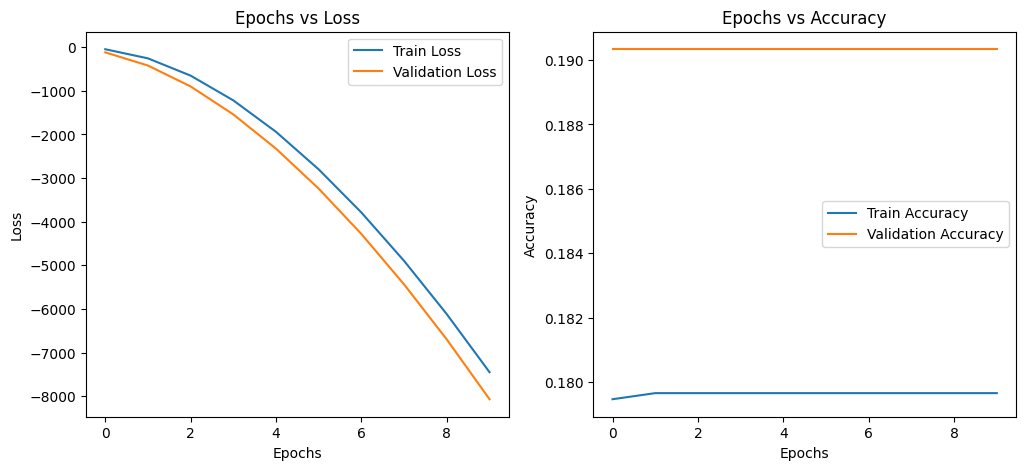

In [54]:
# plot epoch vs loss and epoch vs accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_b_gru.history["loss"], label="Train Loss")
plt.plot(history_b_gru.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_b_gru.history["accuracy"], label="Train Accuracy")
plt.plot(history_b_gru.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend()
plt.show()

# Subtask C

In [58]:
X = df["tweet"]
y_subtask_c = df["subtask_c"]

y_subtask_c.value_counts()

subtask_c
3    9759
1    2407
2    1074
Name: count, dtype: int64

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_subtask_c, test_size=0.2, random_state=42
)

### Vectorizing tweets

In [60]:
tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [61]:
X_train.shape

(10592, 14002)

In [62]:
evaluation_dict_subtask_c = {}

In [67]:
y_subtask_c -= 1

In [68]:
y_subtask_c.value_counts()

subtask_c
2    9759
0    2407
1    1074
Name: count, dtype: int64

## Machine Learning Models
### Logistic Regression

In [72]:
logistic = LogisticRegression(random_state=42)
parameters = {
    "C": [0.1, 1, 10, 100],
}

grid_search = GridSearchCV(logistic, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
logistic = grid_search.best_estimator_
evaluate_model(
    logistic, X_test, y_test, "Logistic Regression", evaluation_dict_subtask_c
)

Classification Report for Logistic Regression
              precision    recall  f1-score   support

           1       0.61      0.22      0.32       504
           2       0.44      0.06      0.10       203
           3       0.77      0.97      0.86      1941

    accuracy                           0.75      2648
   macro avg       0.61      0.41      0.43      2648
weighted avg       0.71      0.75      0.70      2648



c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



### Support Vector Machine

In [73]:
svm = SVC(random_state=42)
parameters = {"C": [0.1, 1, 10]}

grid_search = GridSearchCV(svm, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
svm = grid_search.best_estimator_
evaluate_model(svm, X_test, y_test, "SVM", evaluation_dict_subtask_c)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Classification Report for SVM
              precision    recall  f1-score   support

           1       0.63      0.27      0.37       504
           2       0.34      0.05      0.09       203
           3       0.78      0.96      0.86      1941

    accuracy                           0.76      2648
   macro avg       0.58      0.43      0.44      2648
weighted avg       0.72      0.76      0.71      2648



c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



Best Parameters: {'C': 10}
Best Score: 0.7546253355026535


### Gaussian Naive Bayes


In [74]:
naive_bayes = MultinomialNB()
parameters = {"alpha": [0.1, 0.5, 1.0], "fit_prior": [True, False]}

grid_search = GridSearchCV(naive_bayes, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
naive_bayes = grid_search.best_estimator_
evaluate_model(naive_bayes, X_test, y_test, "Naive Bayes", evaluation_dict_subtask_c)

Classification Report for Naive Bayes
              precision    recall  f1-score   support

           1       0.64      0.05      0.09       504
           2       0.00      0.00      0.00       203
           3       0.74      1.00      0.85      1941

    accuracy                           0.74      2648
   macro avg       0.46      0.35      0.31      2648
weighted avg       0.66      0.74      0.64      2648



c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Random Forest Classifier

In [75]:
random_forest = RandomForestClassifier(random_state=42)
parameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 50, 100, None],
}

grid_search = GridSearchCV(random_forest, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
random_forest = grid_search.best_estimator_
evaluate_model(
    random_forest, X_test, y_test, "Random Forest", evaluation_dict_subtask_c
)

Classification Report for Random Forest
              precision    recall  f1-score   support

           1       0.55      0.27      0.37       504
           2       0.33      0.01      0.03       203
           3       0.78      0.95      0.86      1941

    accuracy                           0.75      2648
   macro avg       0.55      0.41      0.42      2648
weighted avg       0.70      0.75      0.70      2648



c:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



## Deep Learning Models
### LSTM Model

In [76]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["tweet"])
X = pad_sequences(tokenizer.texts_to_sequences(df["tweet"]), maxlen=50, padding="post")
y_subtask_c = df["subtask_c"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_subtask_c, test_size=0.2, random_state=42
)
model_c_lstm = Sequential(
    [
        Embedding(input_dim=5000, output_dim=64),
        LSTM(64, return_sequences=True),
        Dropout(0.5),
        LSTM(32),
        Dense(16, activation="relu"),
        Dense(3, activation="softmax"),  # Three classes
    ]
)
model_c_lstm.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history_c_lstm = model_c_lstm.fit(
    X_train, y_train, epochs=10, validation_data=(X_test, y_test)
)

Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.7268 - loss: 0.7804 - val_accuracy: 0.7330 - val_loss: 0.7426
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7349 - loss: 0.7438 - val_accuracy: 0.7330 - val_loss: 0.7411
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7331 - loss: 0.7474 - val_accuracy: 0.7330 - val_loss: 0.7430
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7438 - loss: 0.7049 - val_accuracy: 0.7334 - val_loss: 0.7077
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7431 - loss: 0.6194 - val_accuracy: 0.7402 - val_loss: 0.6937
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7842 - loss: 0.5471 - val_accuracy: 0.7315 - val_loss: 0.7247
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8129 - loss: 0.4873 - val_accuracy: 0.7073 - val_loss: 0.7290
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8244 - loss: 0.4598 - 

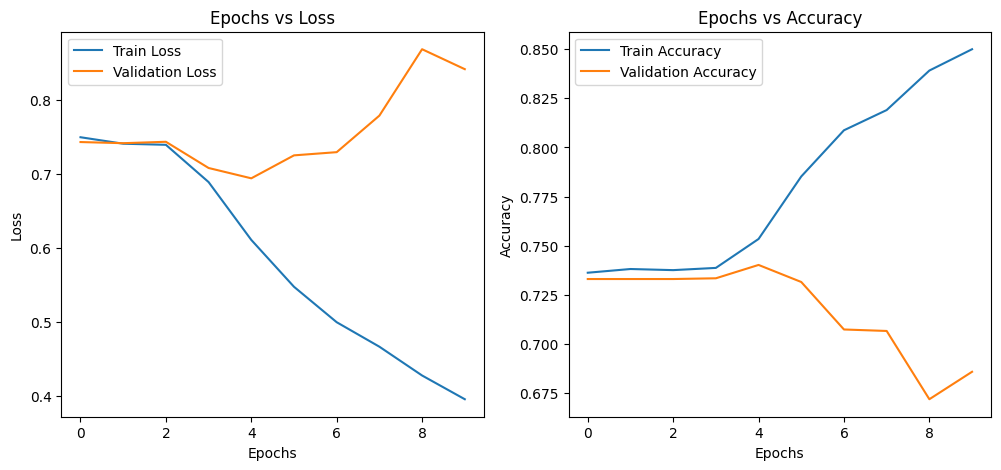

In [78]:
# plot epoch vs loss and epoch vs accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_c_lstm.history["loss"], label="Train Loss")
plt.plot(history_c_lstm.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_c_lstm.history["accuracy"], label="Train Accuracy")
plt.plot(history_c_lstm.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend()
plt.show()

### GRU Model

In [77]:
model_c_gru = Sequential(
    [
        Embedding(input_dim=5000, output_dim=64),
        GRU(64, return_sequences=True),
        Dropout(0.5),
        GRU(32),
        Dense(16, activation="relu"),
        Dense(3, activation="softmax"),
    ]
)
model_c_gru.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history_c_gru = model_c_gru.fit(
    X_train, y_train, epochs=10, validation_data=(X_test, y_test)
)

Epoch 1/10


c:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.7115 - loss: 0.7981 - val_accuracy: 0.7330 - val_loss: 0.7491
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7351 - loss: 0.7456 - val_accuracy: 0.7334 - val_loss: 0.7042
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.7559 - loss: 0.6405 - val_accuracy: 0.7504 - val_loss: 0.6562
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8024 - loss: 0.5067 - val_accuracy: 0.7300 - val_loss: 0.6875
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.8588 - loss: 0.3886 - val_accuracy: 0.7171 - val_loss: 0.7505
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8984 - loss: 0.3032 - val_accuracy: 0.6990 - val_loss: 0.8562
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9257 - loss: 0.2362 - val_accuracy: 0.7160 - val_loss: 0.9765
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9469 - loss: 0.1810 - val_accurac

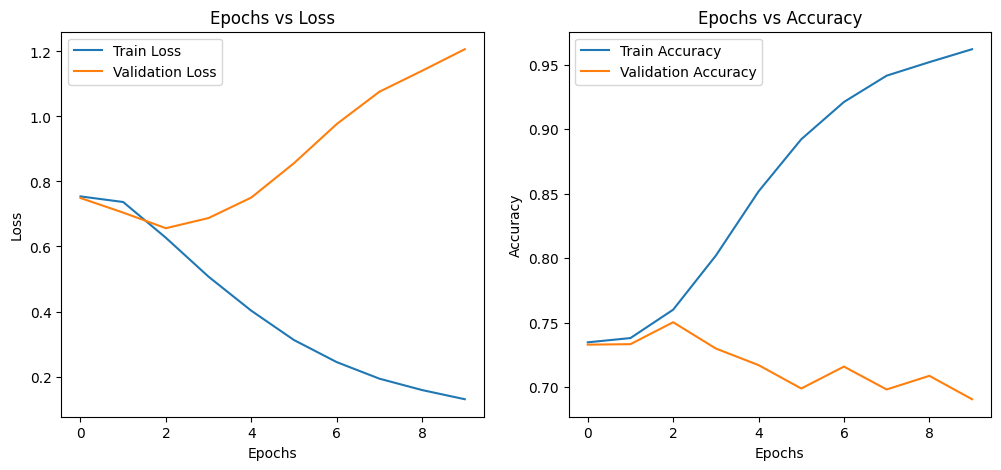

In [79]:
# plot epoch vs loss and epoch vs accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_c_gru.history["loss"], label="Train Loss")
plt.plot(history_c_gru.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_c_gru.history["accuracy"], label="Train Accuracy")
plt.plot(history_c_gru.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend()
plt.show()